# Analisis Income Dataset dengan Boosting dan Bagging (Revised)

## 1. Import Library

In [27]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Ensemble methods - Bagging
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Ensemble methods - Boosting
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import roc_auc_score

# Setting
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set(style='whitegrid')
pd.set_option('display.max_columns', None)

## 2. Load dan Explorasi Data

In [28]:
# Load dataset
df_income = pd.read_csv('income.csv')

# Melihat 5 data pertama
print("Dataset Income:")
df_income.head()

Dataset Income:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [29]:
# Melihat informasi dataset
print("\nInformasi Dataset:")
print(df_income.info())

print("\nStatistik Deskriptif:")
df_income.describe()


Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None

Statistik Deskriptif:


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [30]:
# Memeriksa nilai yang hilang
print("\nNilai yang Hilang:")
print(df_income.isnull().sum())

# Distribusi data target dan unik valuesnya
print("\nDistribusi Kelas Target:")
print(df_income['income'].value_counts())
print("\nNilai unik dalam target:", df_income['income'].unique())
print(f"\nJumlah kelas dalam target: {len(df_income['income'].unique())}")
print(f"Persentase kelas >50K: {(df_income['income'].str.contains('>50K')).mean()*100:.2f}%")


Nilai yang Hilang:
age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

Distribusi Kelas Target:
income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64

Nilai unik dalam target: ['<=50K' '>50K' '<=50K.' '>50K.']

Jumlah kelas dalam target: 4
Persentase kelas >50K: 23.93%


In [31]:
# Periksa nilai unik untuk kolom kategorikal
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation',
                     'relationship', 'race', 'sex', 'native-country']

for col in categorical_cols:
    print(f"\nUnique values in {col}:")
    print(df_income[col].value_counts().sort_values(ascending=False).head(10))


Unique values in workclass:
workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
?                    1836
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64

Unique values in education:
education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
Name: count, dtype: int64

Unique values in marital-status:
marital-status
Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: count, dtype: int64

Unique values in occupation:
occupation
Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-c

## 3. Analisis Data Eksploratori (EDA)

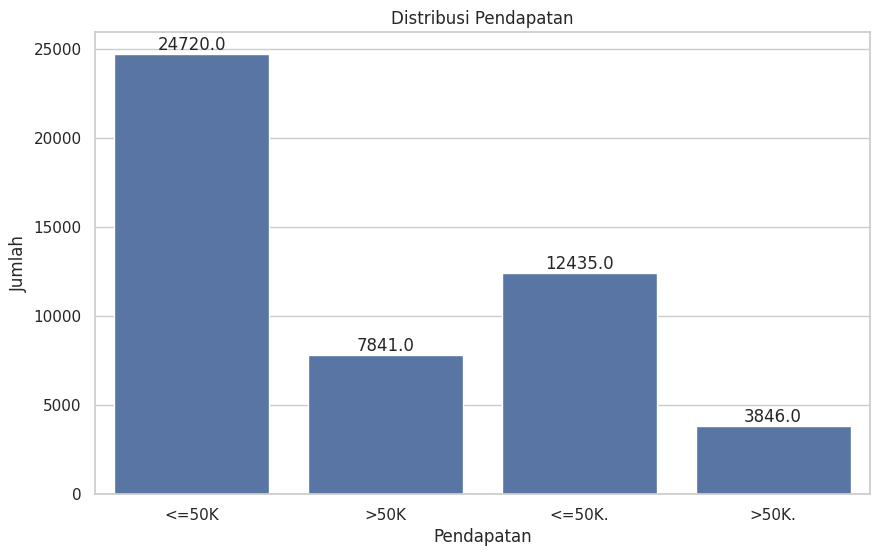

In [32]:
# Visualisasi distribusi kelas target
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='income', data=df_income)
plt.title('Distribusi Pendapatan')
plt.xlabel('Pendapatan')
plt.ylabel('Jumlah')

# Tambahkan label jumlah di atas bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'bottom')

plt.show()

In [33]:
# Membersihkan dan konversi target ke binary (0: <=50K, 1: >50K)
# Strip whitespace dan standardize format
df_income['income_clean'] = df_income['income'].str.strip()

# Check nilai unik setelah dibersihkan
print("Nilai unik setelah pembersihan:", df_income['income_clean'].unique())

# Konversi ke binary
df_income['income_binary'] = df_income['income_clean'].apply(lambda x: 1 if '>' in x else 0)

# Periksa hasil konversi
print("\nDistribusi target setelah konversi binary:")
print(df_income['income_binary'].value_counts())
print(f"Persentase kelas 1 (>50K): {df_income['income_binary'].mean()*100:.2f}%")

Nilai unik setelah pembersihan: ['<=50K' '>50K' '<=50K.' '>50K.']

Distribusi target setelah konversi binary:
income_binary
0    37155
1    11687
Name: count, dtype: int64
Persentase kelas 1 (>50K): 23.93%


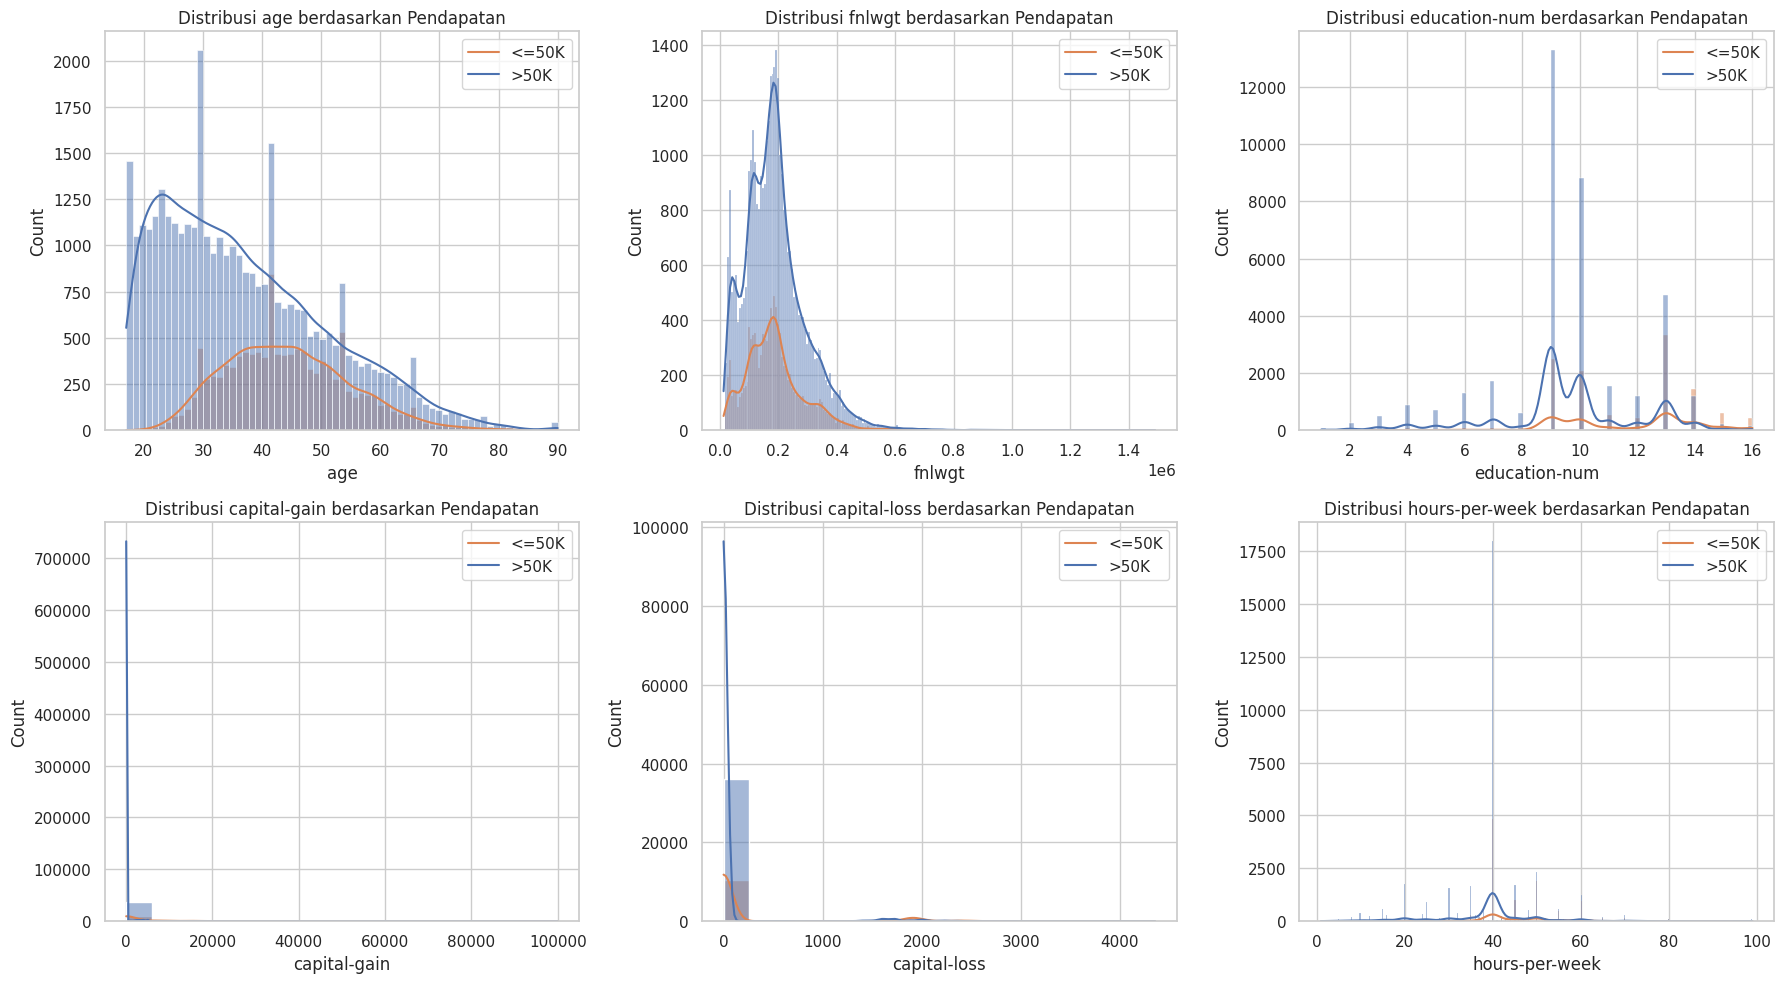

In [34]:
# Visualisasi distribusi fitur numerik berdasarkan pendapatan
numerical_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(data=df_income, x=col, hue='income_binary', kde=True, ax=axes[i])
    axes[i].set_title(f'Distribusi {col} berdasarkan Pendapatan')
    axes[i].set_xlabel(col)
    axes[i].legend(['<=50K', '>50K'])

plt.tight_layout()
plt.show()

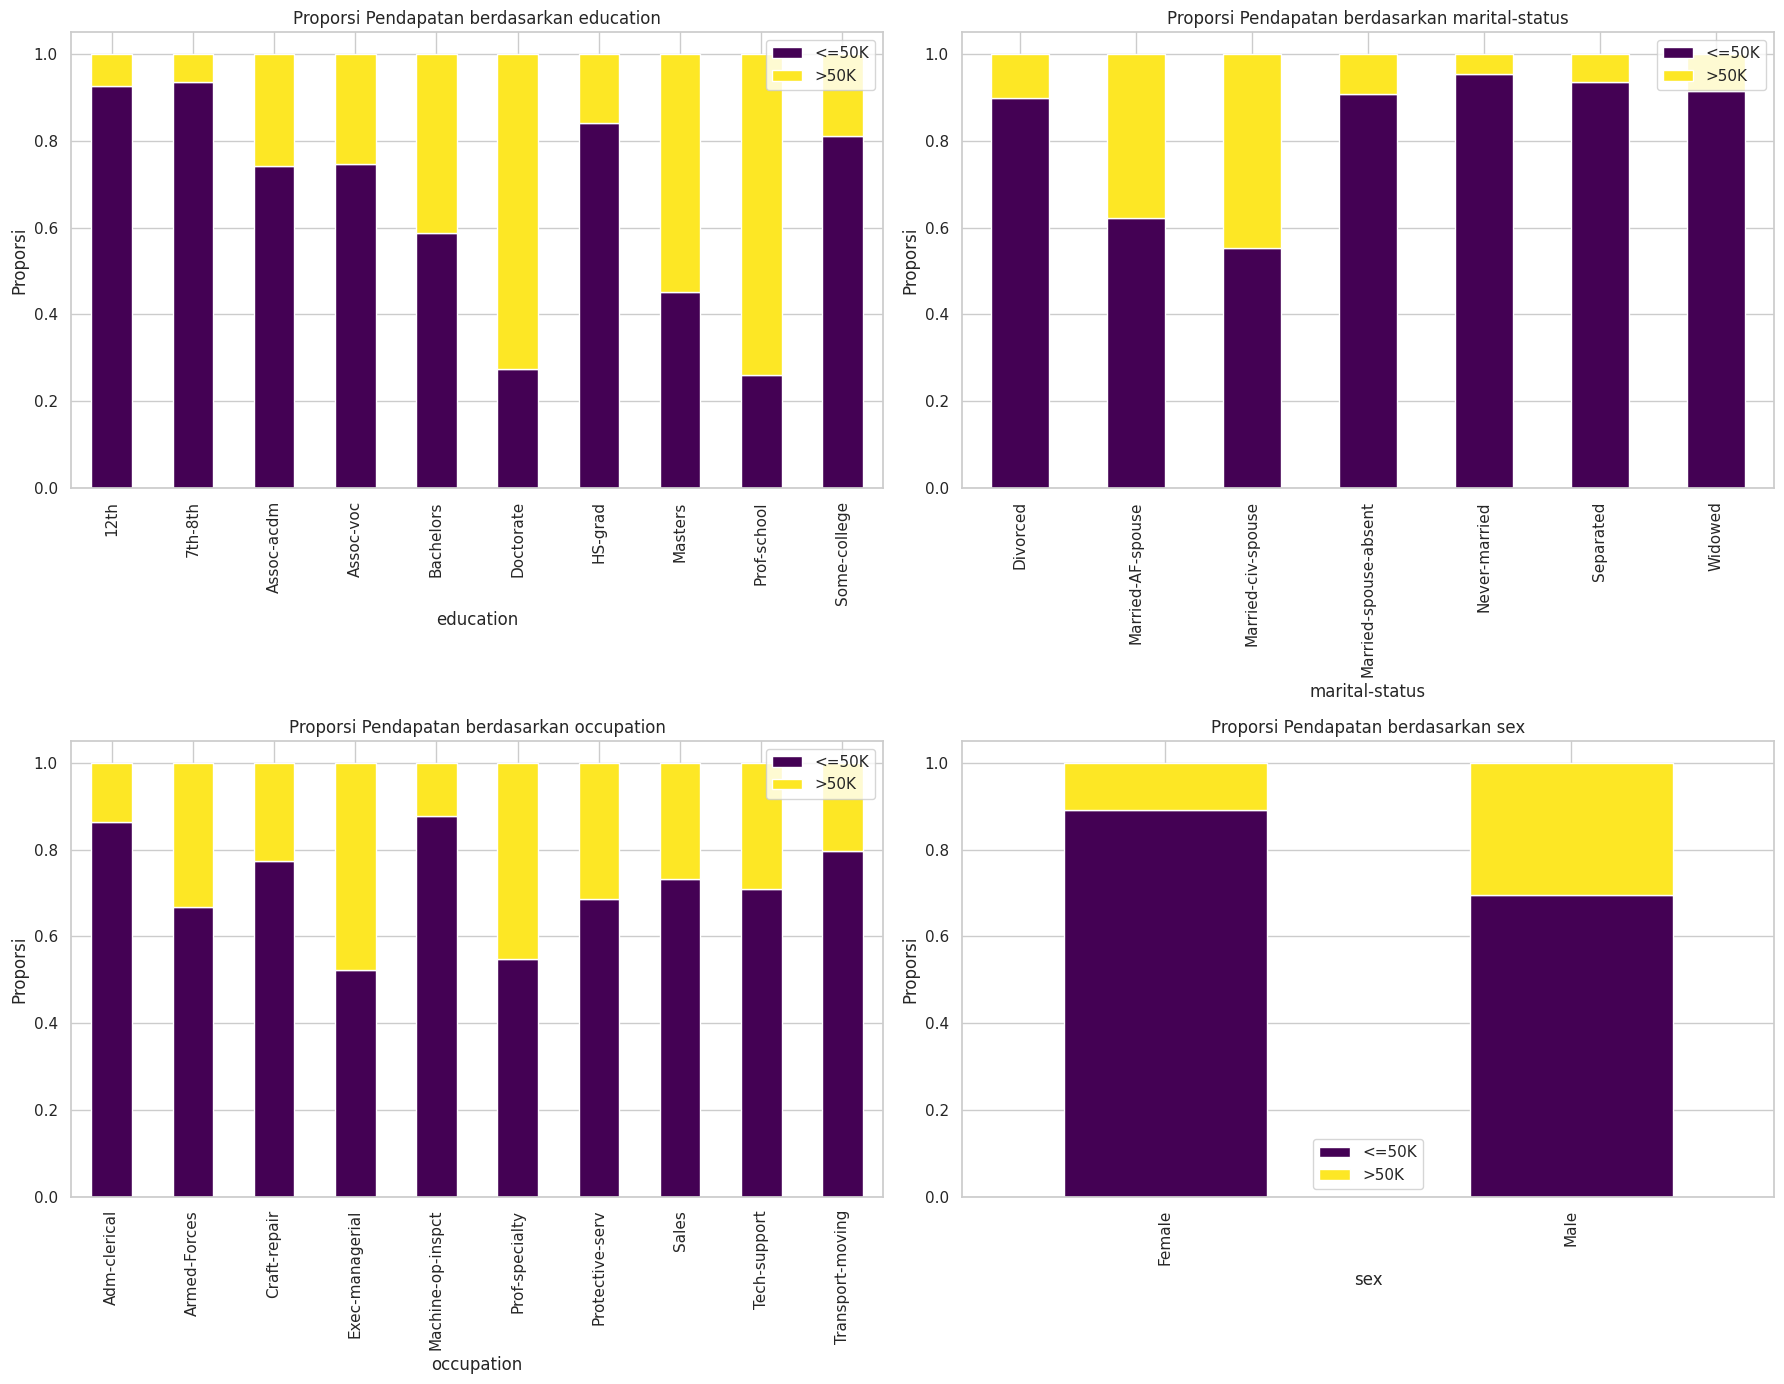

In [35]:
# Visualisasi kategorikal penting vs target
important_cat_cols = ['education', 'marital-status', 'occupation', 'sex']

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for i, col in enumerate(important_cat_cols):
    # Calculate proportion of >50K for each category
    prop_high_income = df_income.groupby(col)['income_binary'].mean().sort_values(ascending=False)

    # Use only top 10 categories to avoid cluttering
    if len(prop_high_income) > 10:
        categories = prop_high_income.index[:10]
        data_subset = df_income[df_income[col].isin(categories)]
    else:
        data_subset = df_income
        categories = prop_high_income.index

    # Plot stacked bar
    income_pivot = pd.crosstab(data_subset[col], data_subset['income_binary'], normalize='index')
    income_pivot.plot(kind='bar', stacked=True, ax=axes[i], colormap='viridis')

    axes[i].set_title(f'Proporsi Pendapatan berdasarkan {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Proporsi')
    axes[i].legend(['<=50K', '>50K'])

plt.tight_layout()
plt.show()

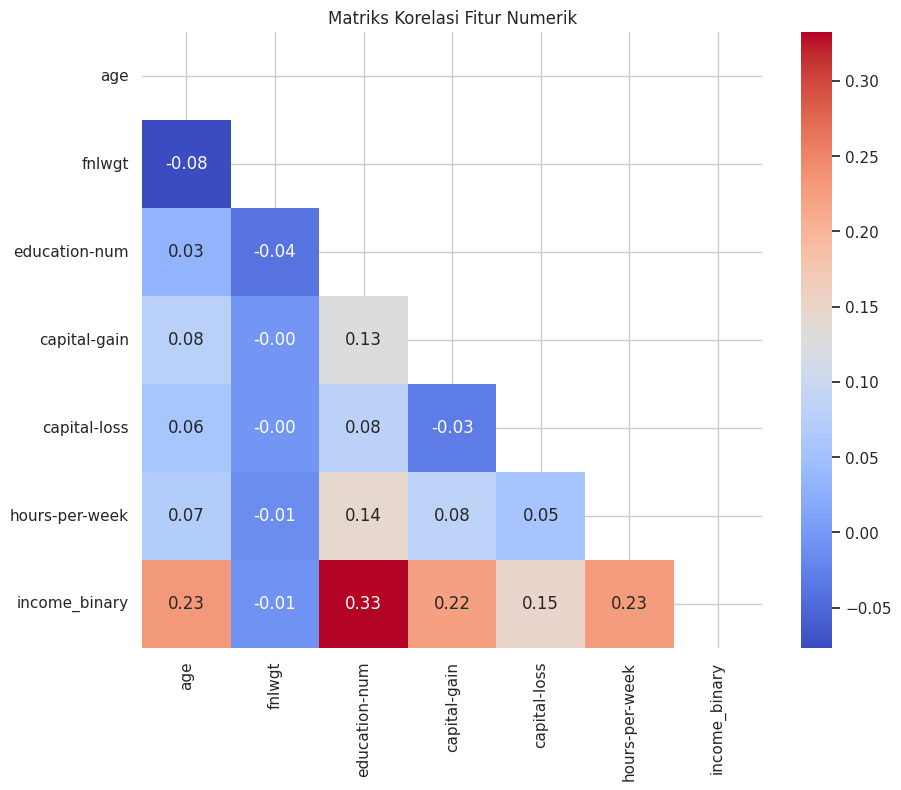

In [36]:
# Visualisasi korelasi untuk fitur numerik
plt.figure(figsize=(10, 8))
correlation = df_income[numerical_cols + ['income_binary']].corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
plt.title('Matriks Korelasi Fitur Numerik')
plt.show()

## 4. Preprocessing Data

In [37]:
# Handling missing values dan nilai '?' pada data kategorik
# Cek kolom dengan nilai '?'
for col in categorical_cols:
    count_missing = (df_income[col] == ' ?').sum()
    if count_missing > 0:
        print(f"Kolom {col} memiliki {count_missing} nilai '?'")
        # Ganti nilai '?' dengan mode (nilai terbanyak)
        most_frequent = df_income[df_income[col] != ' ?'][col].mode()[0]
        df_income[col] = df_income[col].replace(' ?', most_frequent)

In [38]:
# Feature Engineering

# 1. Rasio capital gain dan loss
df_income['capital_ratio'] = df_income['capital-gain'] / (df_income['capital-loss'] + 1)  # +1 untuk menghindari division by zero

# 2. Pendapatan per jam (estimasi)
df_income['income_per_hour'] = df_income['fnlwgt'] / (df_income['hours-per-week'] + 1)

# 3. Interaksi usia dan pendidikan
df_income['age_education'] = df_income['age'] * df_income['education-num']

# 4. Categorical encoding untuk Education (ordinal)
education_order = {
    ' Preschool': 1, ' 1st-4th': 2, ' 5th-6th': 3, ' 7th-8th': 4, ' 9th': 5, ' 10th': 6, ' 11th': 7, ' 12th': 8,
    ' HS-grad': 9, ' Some-college': 10, ' Assoc-voc': 11, ' Assoc-acdm': 12, ' Bachelors': 13, ' Masters': 14,
    ' Prof-school': 15, ' Doctorate': 16
}
df_income['education_ord'] = df_income['education'].map(education_order).fillna(0).astype(int)

# Tambahkan fitur engineered ke daftar numerik
numerical_cols.extend(['capital_ratio', 'income_per_hour', 'age_education', 'education_ord'])

print("Feature engineering berhasil dilakukan")

Feature engineering berhasil dilakukan


In [39]:
# Preprocessing data kategorik dan numerik
# Memisahkan fitur dan target
X = df_income.drop(['income', 'income_clean', 'income_binary'], axis=1)
y = df_income['income_binary']  # Gunakan target binary

# Identifikasi kolom numerik dan kategorikal
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation',
                     'relationship', 'race', 'sex', 'native-country']

# Membuat preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

# Membagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit dan transform data train
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Bentuk data setelah preprocessing:")
print(f"X_train: {X_train_processed.shape}")
print(f"X_test: {X_test_processed.shape}")

Bentuk data setelah preprocessing:
X_train: (39073, 112)
X_test: (9769, 112)


## 5. Membuat dan Melatih Model Ensemble

### 5.1 Metode Bagging


--- Random Forest Model ---
Hasil Evaluasi Random Forest:
Accuracy: 0.8586
Precision: 0.7443
Recall: 0.6236
F1-Score: 0.6786
ROC AUC: 0.9085

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      7431
           1       0.74      0.62      0.68      2338

    accuracy                           0.86      9769
   macro avg       0.82      0.78      0.79      9769
weighted avg       0.85      0.86      0.85      9769



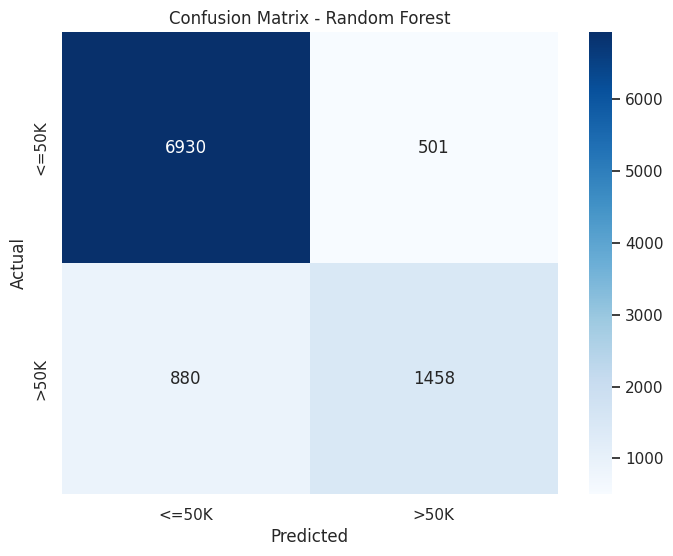

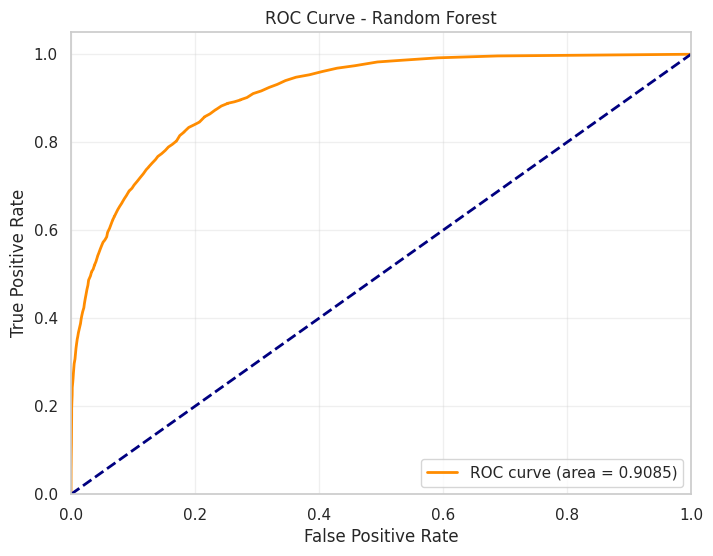

In [40]:
# Model Bagging 1: Random Forest
print("\n--- Random Forest Model ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_processed, y_train)

# Prediksi
y_pred_rf = rf_model.predict(X_test_processed)
y_prob_rf = rf_model.predict_proba(X_test_processed)[:, 1]

# Metrik evaluasi
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

print("Hasil Evaluasi Random Forest:")
print(f"Accuracy: {acc_rf:.4f}")
print(f"Precision: {prec_rf:.4f}")
print(f"Recall: {rec_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")
print(f"ROC AUC: {roc_auc_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['<=50K', '>50K'],
            yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()


--- Bagging Classifier Model ---
Hasil Evaluasi Bagging Classifier:
Accuracy: 0.8561
Precision: 0.7400
Recall: 0.6146
F1-Score: 0.6715
ROC AUC: 0.9048

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      7431
           1       0.74      0.61      0.67      2338

    accuracy                           0.86      9769
   macro avg       0.81      0.77      0.79      9769
weighted avg       0.85      0.86      0.85      9769



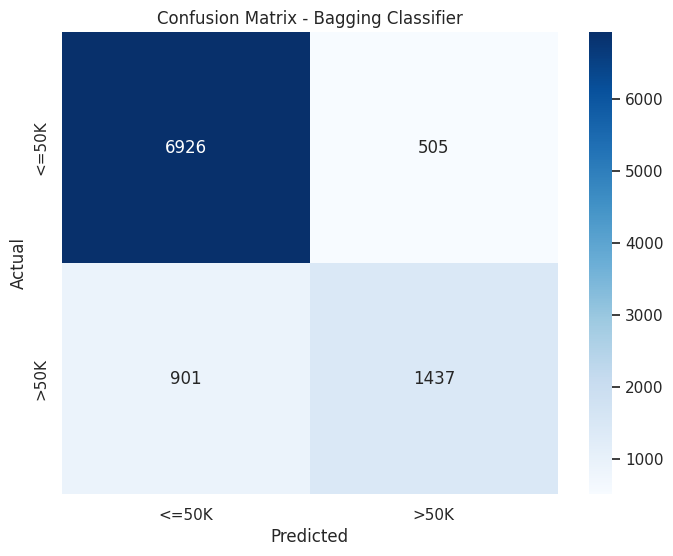

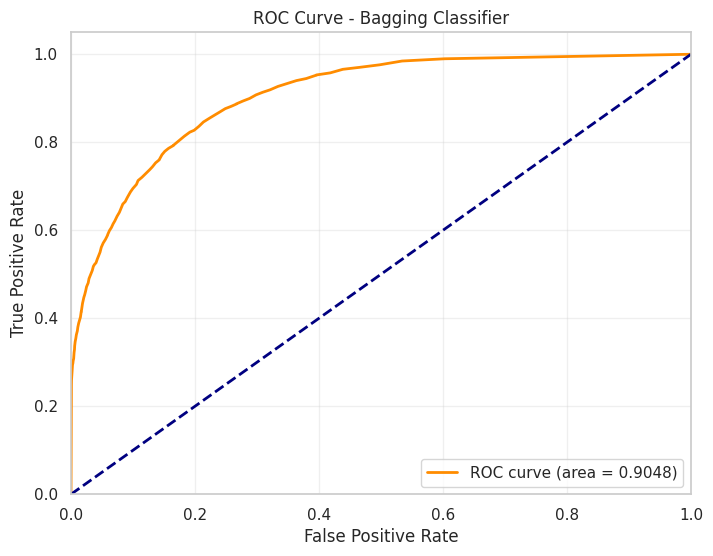

In [41]:
# Model Bagging 2: Bagging Classifier dengan base estimator Decision Tree
print("\n--- Bagging Classifier Model ---")
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)
bagging_model.fit(X_train_processed, y_train)

# Prediksi
y_pred_bag = bagging_model.predict(X_test_processed)
y_prob_bag = bagging_model.predict_proba(X_test_processed)[:, 1]

# Metrik evaluasi
acc_bag = accuracy_score(y_test, y_pred_bag)
prec_bag = precision_score(y_test, y_pred_bag)
rec_bag = recall_score(y_test, y_pred_bag)
f1_bag = f1_score(y_test, y_pred_bag)
roc_auc_bag = roc_auc_score(y_test, y_prob_bag)

print("Hasil Evaluasi Bagging Classifier:")
print(f"Accuracy: {acc_bag:.4f}")
print(f"Precision: {prec_bag:.4f}")
print(f"Recall: {rec_bag:.4f}")
print(f"F1-Score: {f1_bag:.4f}")
print(f"ROC AUC: {roc_auc_bag:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bag))

# Confusion matrix
cm_bag = confusion_matrix(y_test, y_pred_bag)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bag, annot=True, fmt='d', cmap='Blues',
            xticklabels=['<=50K', '>50K'],
            yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Bagging Classifier')
plt.show()

# ROC Curve
fpr_bag, tpr_bag, _ = roc_curve(y_test, y_prob_bag)

plt.figure(figsize=(8, 6))
plt.plot(fpr_bag, tpr_bag, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_bag:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Bagging Classifier')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

### 5.2 Metode Boosting


--- AdaBoost Model ---
Hasil Evaluasi AdaBoost:
Accuracy: 0.8563
Precision: 0.7530
Recall: 0.5945
F1-Score: 0.6644
ROC AUC: 0.9109

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      7431
           1       0.75      0.59      0.66      2338

    accuracy                           0.86      9769
   macro avg       0.82      0.77      0.79      9769
weighted avg       0.85      0.86      0.85      9769



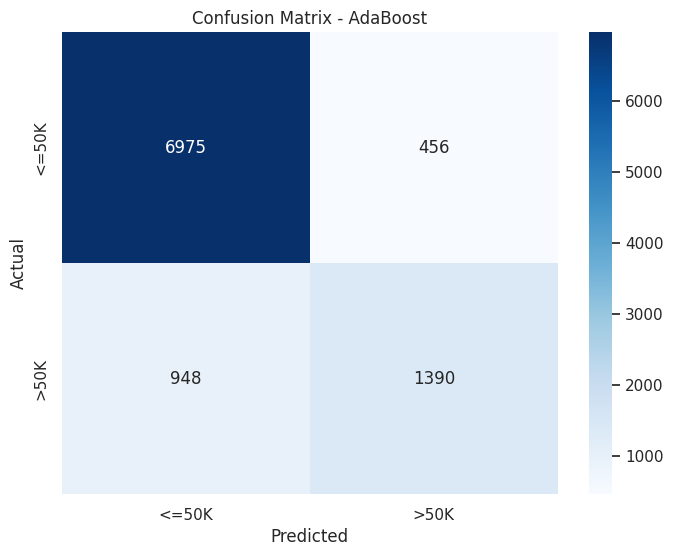

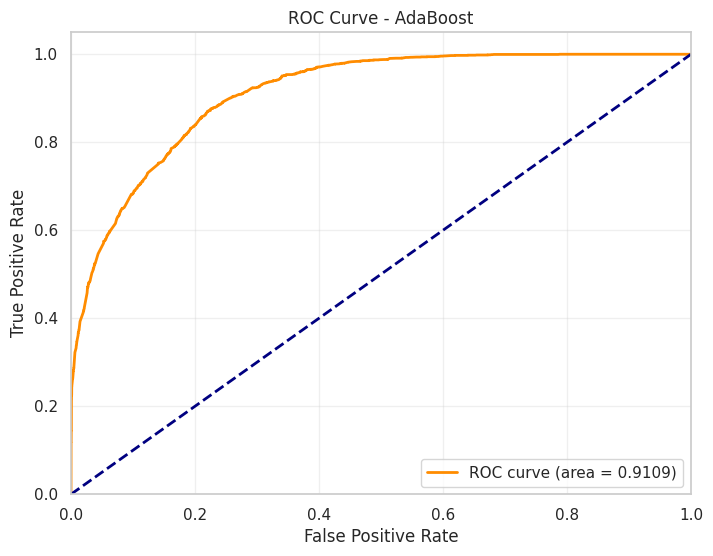

In [42]:
# Model Boosting 1: AdaBoost
print("\n--- AdaBoost Model ---")
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train_processed, y_train)

# Prediksi
y_pred_ada = ada_model.predict(X_test_processed)
y_prob_ada = ada_model.predict_proba(X_test_processed)[:, 1]

# Metrik evaluasi
acc_ada = accuracy_score(y_test, y_pred_ada)
prec_ada = precision_score(y_test, y_pred_ada)
rec_ada = recall_score(y_test, y_pred_ada)
f1_ada = f1_score(y_test, y_pred_ada)
roc_auc_ada = roc_auc_score(y_test, y_prob_ada)

print("Hasil Evaluasi AdaBoost:")
print(f"Accuracy: {acc_ada:.4f}")
print(f"Precision: {prec_ada:.4f}")
print(f"Recall: {rec_ada:.4f}")
print(f"F1-Score: {f1_ada:.4f}")
print(f"ROC AUC: {roc_auc_ada:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ada))

# Confusion matrix
cm_ada = confusion_matrix(y_test, y_pred_ada)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Blues',
            xticklabels=['<=50K', '>50K'],
            yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - AdaBoost')
plt.show()

# ROC Curve
fpr_ada, tpr_ada, _ = roc_curve(y_test, y_prob_ada)

plt.figure(figsize=(8, 6))
plt.plot(fpr_ada, tpr_ada, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_ada:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - AdaBoost')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()


--- Gradient Boosting Model ---
Hasil Evaluasi Gradient Boosting:
Accuracy: 0.8700
Precision: 0.7886
Recall: 0.6240
F1-Score: 0.6968
ROC AUC: 0.9234

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      7431
           1       0.79      0.62      0.70      2338

    accuracy                           0.87      9769
   macro avg       0.84      0.79      0.81      9769
weighted avg       0.86      0.87      0.86      9769



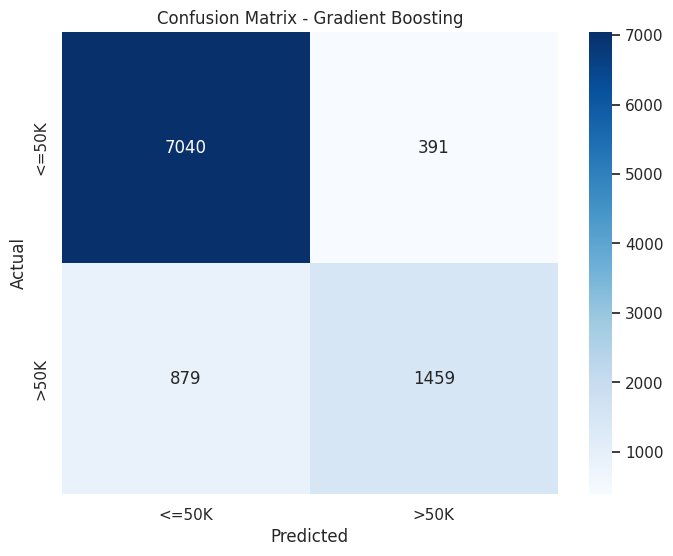

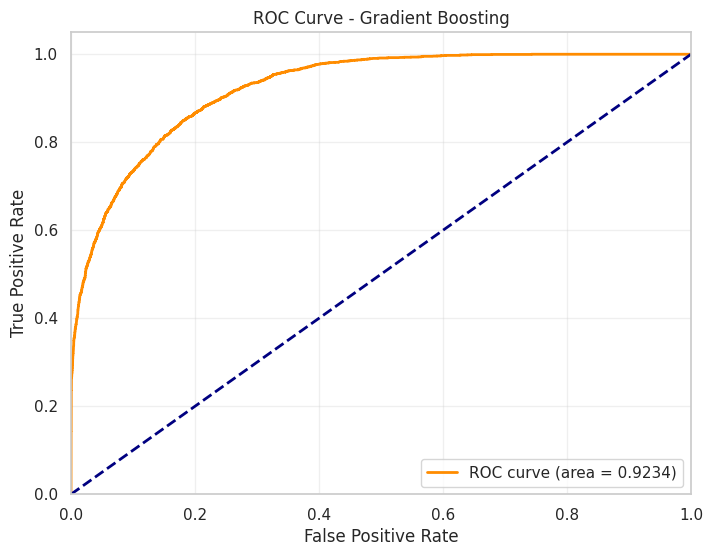

In [43]:
# Model Boosting 2: Gradient Boosting
print("\n--- Gradient Boosting Model ---")
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_processed, y_train)

# Prediksi
y_pred_gb = gb_model.predict(X_test_processed)
y_prob_gb = gb_model.predict_proba(X_test_processed)[:, 1]

# Metrik evaluasi
acc_gb = accuracy_score(y_test, y_pred_gb)
prec_gb = precision_score(y_test, y_pred_gb)
rec_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_prob_gb)

print("Hasil Evaluasi Gradient Boosting:")
print(f"Accuracy: {acc_gb:.4f}")
print(f"Precision: {prec_gb:.4f}")
print(f"Recall: {rec_gb:.4f}")
print(f"F1-Score: {f1_gb:.4f}")
print(f"ROC AUC: {roc_auc_gb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))

# Confusion matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['<=50K', '>50K'],
            yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Gradient Boosting')
plt.show()

# ROC Curve
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_gb:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()


--- XGBoost Model ---
Hasil Evaluasi XGBoost:
Accuracy: 0.8737
Precision: 0.7730
Recall: 0.6685
F1-Score: 0.7170
ROC AUC: 0.9291

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7431
           1       0.77      0.67      0.72      2338

    accuracy                           0.87      9769
   macro avg       0.84      0.80      0.82      9769
weighted avg       0.87      0.87      0.87      9769



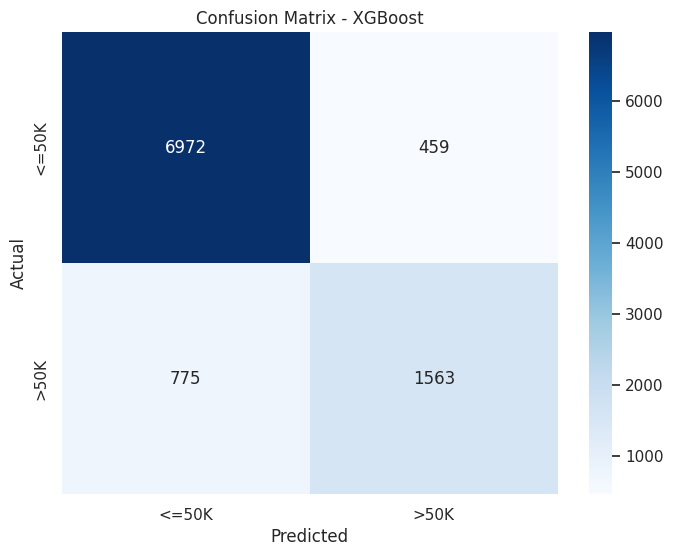

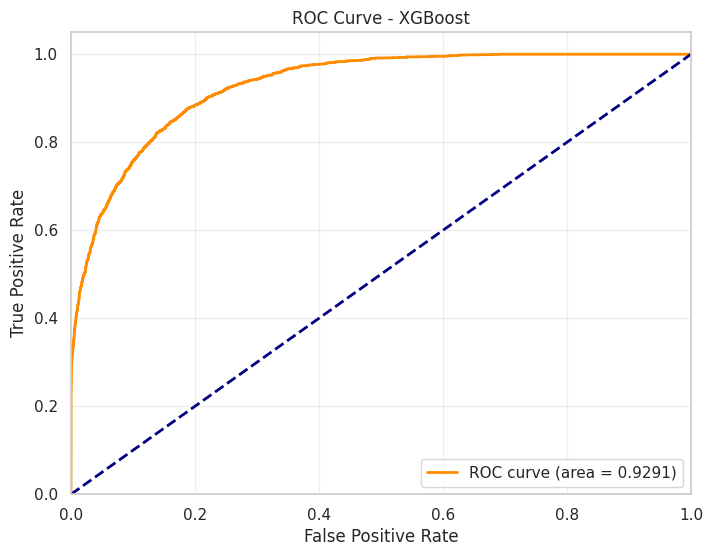

In [44]:
# Model Boosting 3: XGBoost
print("\n--- XGBoost Model ---")
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train_processed, y_train)

# Prediksi
y_pred_xgb = xgb_model.predict(X_test_processed)
y_prob_xgb = xgb_model.predict_proba(X_test_processed)[:, 1]

# Metrik evaluasi
acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb)
rec_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)

print("Hasil Evaluasi XGBoost:")
print(f"Accuracy: {acc_xgb:.4f}")
print(f"Precision: {prec_xgb:.4f}")
print(f"Recall: {rec_xgb:.4f}")
print(f"F1-Score: {f1_xgb:.4f}")
print(f"ROC AUC: {roc_auc_xgb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['<=50K', '>50K'],
            yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

## 6. Perbandingan Model

In [45]:
# Kumpulkan semua metrik evaluasi
models = ['Random Forest', 'Bagging Classifier', 'AdaBoost', 'Gradient Boosting', 'XGBoost']
accuracy = [acc_rf, acc_bag, acc_ada, acc_gb, acc_xgb]
precision = [prec_rf, prec_bag, prec_ada, prec_gb, prec_xgb]
recall = [rec_rf, rec_bag, rec_ada, rec_gb, rec_xgb]
f1 = [f1_rf, f1_bag, f1_ada, f1_gb, f1_xgb]
auc_scores = [roc_auc_rf, roc_auc_bag, roc_auc_ada, roc_auc_gb, roc_auc_xgb]

# Buat DataFrame untuk perbandingan
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC': auc_scores
})

print("Perbandingan Metrik Evaluasi:")
comparison_df

Perbandingan Metrik Evaluasi:


,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,Random Forest,0.858634,0.744257,0.623610,0.678613,0.908466
1,Bagging Classifier,0.856075,0.739959,0.614628,0.671495,0.904755
2,AdaBoost,0.856280,0.752979,0.594525,0.664436,0.910893
3,Gradient Boosting,0.869997,0.788649,0.624038,0.696753,0.923431
4,XGBoost,0.873682,0.772997,0.668520,0.716972,0.929052


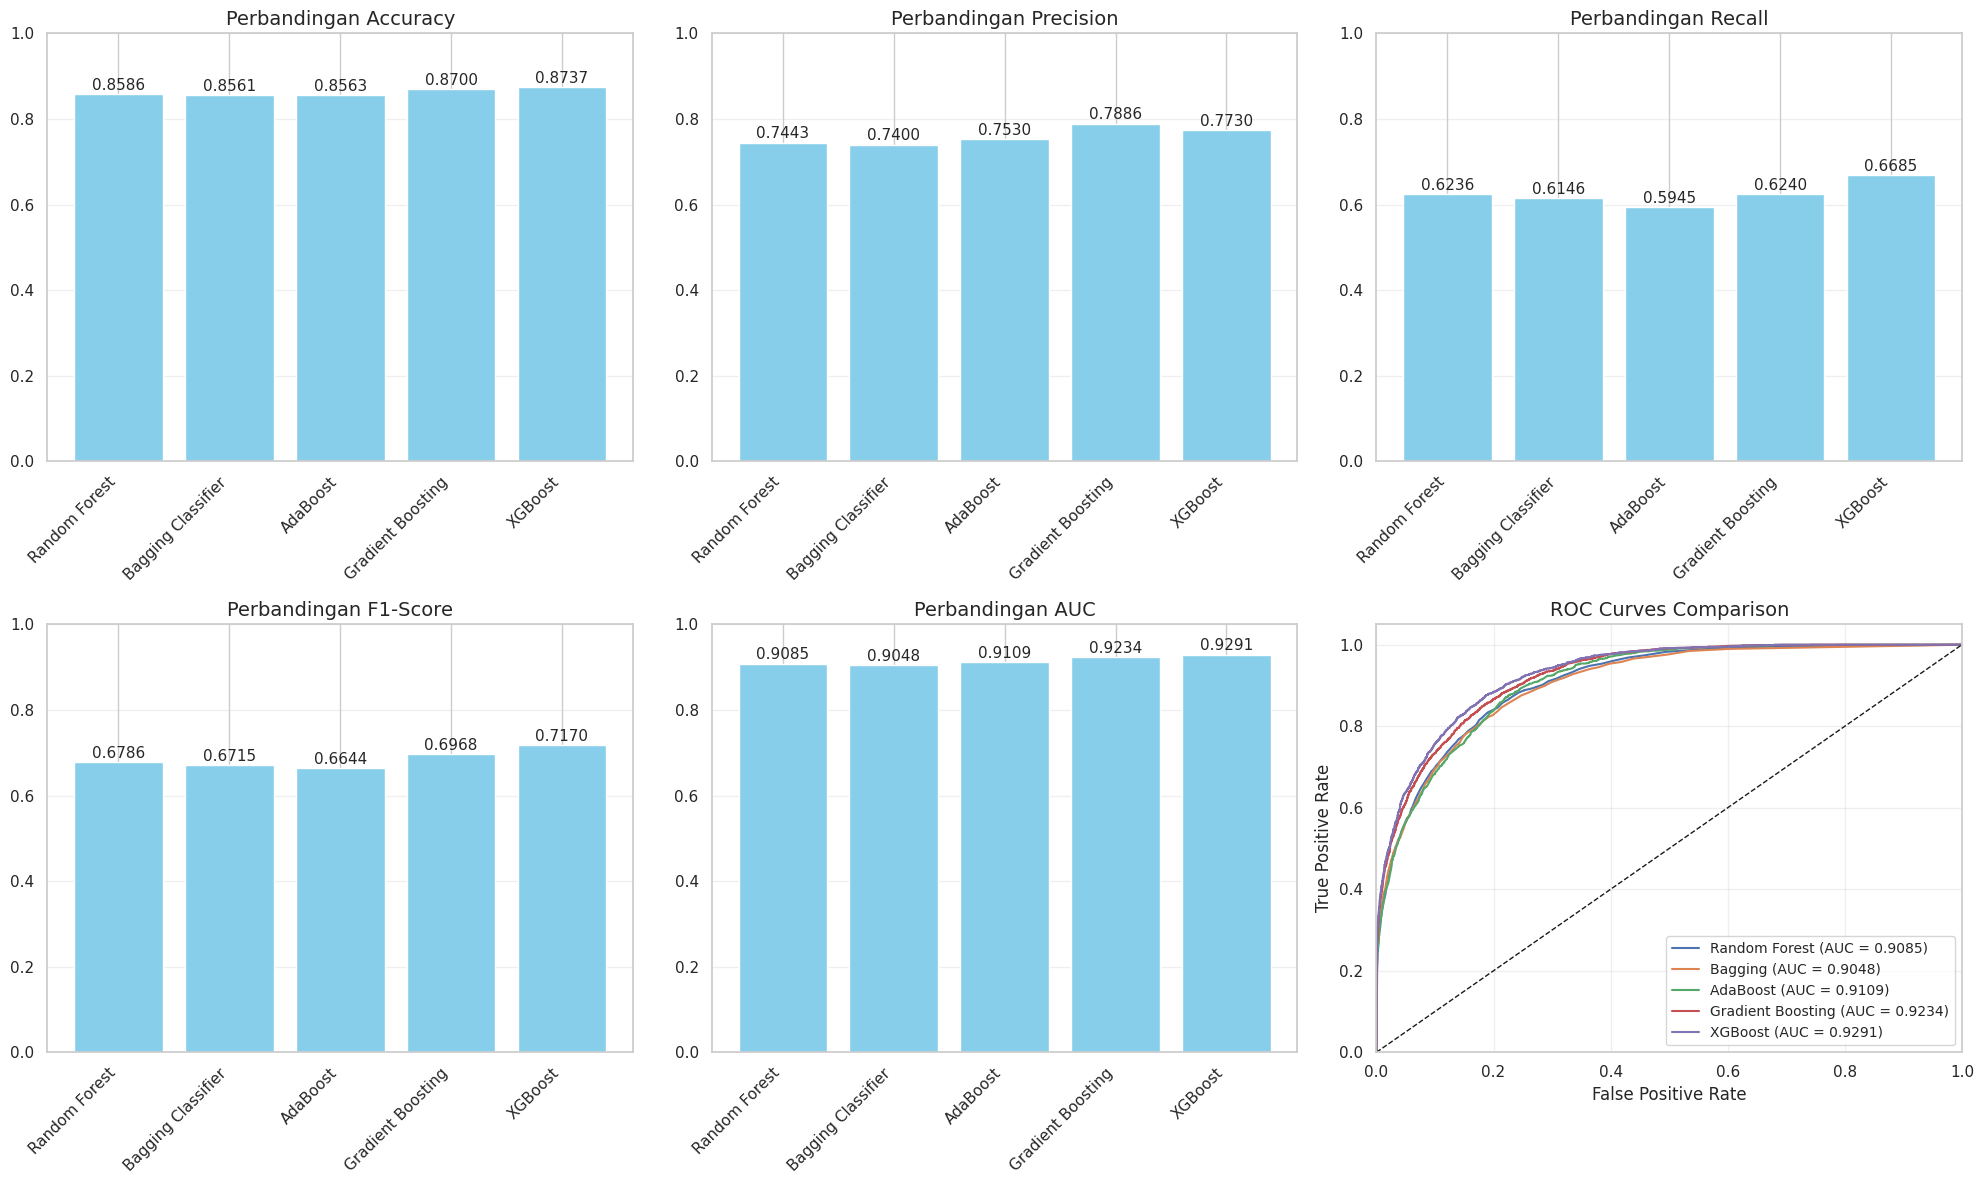

In [46]:
# Visualisasi perbandingan metrik
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metric_values = [accuracy, precision, recall, f1, auc_scores]

for i, (metric, values) in enumerate(zip(metrics, metric_values)):
    axes[i].bar(models, values, color='skyblue')
    axes[i].set_title(f'Perbandingan {metric}', fontsize=14)
    axes[i].set_xticklabels(models, rotation=45, ha='right')
    axes[i].set_ylim(0, 1)
    axes[i].grid(axis='y', alpha=0.3)

    # Menambahkan nilai di atas bar
    for j, v in enumerate(values):
        axes[i].text(j, v + 0.01, f'{v:.4f}', ha='center', fontsize=11)

# ROC Curves Comparison
axes[5].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
axes[5].plot(fpr_bag, tpr_bag, label=f'Bagging (AUC = {roc_auc_bag:.4f})')
axes[5].plot(fpr_ada, tpr_ada, label=f'AdaBoost (AUC = {roc_auc_ada:.4f})')
axes[5].plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.4f})')
axes[5].plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')
axes[5].plot([0, 1], [0, 1], 'k--', lw=1)
axes[5].set_xlim([0.0, 1.0])
axes[5].set_ylim([0.0, 1.05])
axes[5].set_xlabel('False Positive Rate', fontsize=12)
axes[5].set_ylabel('True Positive Rate', fontsize=12)
axes[5].set_title('ROC Curves Comparison', fontsize=14)
axes[5].legend(loc="lower right", fontsize=10)
axes[5].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Feature Importance

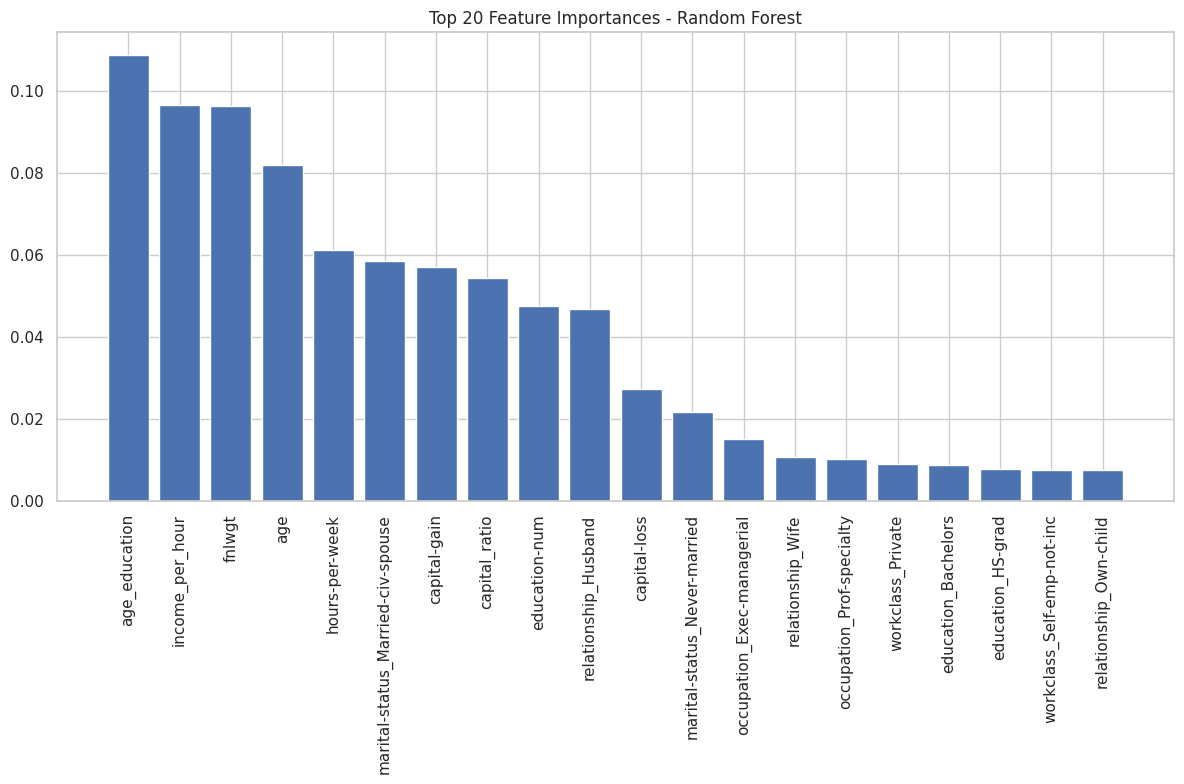

In [47]:
# Analisis Feature Importance dari model Random Forest
# Pertama, dapatkan nama fitur setelah preprocessing
feature_names = []

# Untuk fitur numerik
feature_names.extend(numerical_cols)

# Untuk fitur kategorikal (one-hot encoded)
try:
    categorical_features = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_cols)
    feature_names.extend(categorical_features)
except:
    # Fallback jika metode get_feature_names_out gagal
    print("Tidak dapat mengambil nama fitur kategorik")
    categorical_features = [f"cat_{i}" for i in range(X_train_processed.shape[1] - len(numerical_cols))]
    feature_names.extend(categorical_features)

# Visualisasi top 20 feature importance dari Random Forest
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Hanya tampilkan 20 fitur teratas untuk keterbacaan
top_n = 20
plt.figure(figsize=(12, 8))
plt.title('Top 20 Feature Importances - Random Forest')
plt.bar(range(min(top_n, len(indices))), importances[indices][:top_n], align='center')
plt.xticks(range(min(top_n, len(indices))),
           [feature_names[i] if i < len(feature_names) else f'feature_{i}' for i in indices[:top_n]],
           rotation=90)
plt.tight_layout()
plt.show()

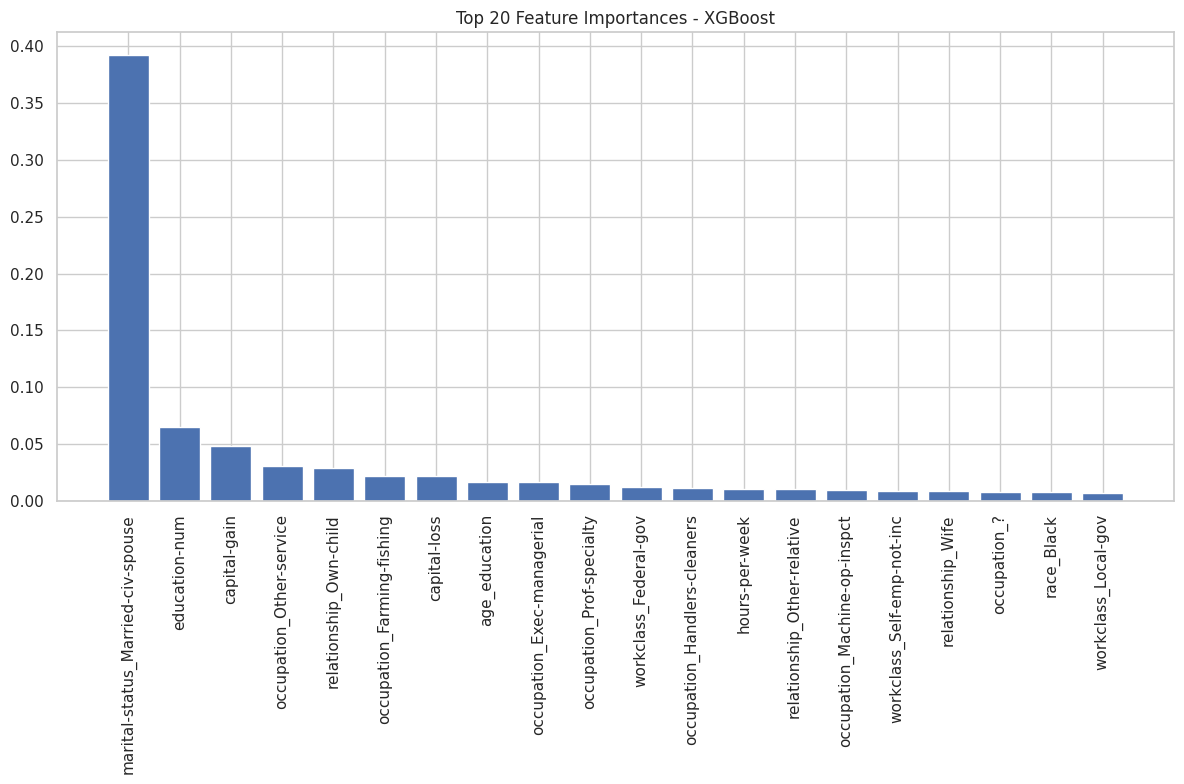

In [48]:
# Visualisasi feature importance dari XGBoost
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Hanya tampilkan 20 fitur teratas
plt.figure(figsize=(12, 8))
plt.title('Top 20 Feature Importances - XGBoost')
plt.bar(range(min(top_n, len(indices))), importances[indices][:top_n], align='center')
plt.xticks(range(min(top_n, len(indices))),
           [feature_names[i] if i < len(feature_names) else f'feature_{i}' for i in indices[:top_n]],
           rotation=90)
plt.tight_layout()
plt.show()

## 8. Hyperparameter Tuning

In [49]:
# Hyperparameter Tuning untuk model terbaik (XGBoost)
from sklearn.model_selection import GridSearchCV

# Definisikan parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

print("Melakukan hyperparameter tuning untuk XGBoost...")
print("Ini mungkin memerlukan beberapa waktu...")

# Grid search dengan 3-fold cross-validation
grid_search = GridSearchCV(
    xgb.XGBClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='roc_auc',  # Gunakan AUC sebagai metrik untuk tuning
    n_jobs=-1,  # Gunakan semua core CPU
    verbose=1
)

grid_search.fit(X_train_processed, y_train)

print(f"\nParameter terbaik: {grid_search.best_params_}")
print(f"ROC AUC terbaik: {grid_search.best_score_:.4f}")

# Evaluasi model terbaik
best_xgb_model = grid_search.best_estimator_
y_pred_xgb_tuned = best_xgb_model.predict(X_test_processed)
y_prob_xgb_tuned = best_xgb_model.predict_proba(X_test_processed)[:, 1]

# Hitung metrik evaluasi
print("\nHasil Evaluasi XGBoost (setelah tuning):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb_tuned):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb_tuned):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_xgb_tuned):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_xgb_tuned):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_tuned))

Melakukan hyperparameter tuning untuk XGBoost...
Ini mungkin memerlukan beberapa waktu...
Fitting 3 folds for each of 72 candidates, totalling 216 fits

Parameter terbaik: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
ROC AUC terbaik: 0.9277

Hasil Evaluasi XGBoost (setelah tuning):
Accuracy: 0.8765
Precision: 0.7912
Recall: 0.6578
F1-Score: 0.7184
ROC AUC: 0.9312

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      7431
           1       0.79      0.66      0.72      2338

    accuracy                           0.88      9769
   macro avg       0.84      0.80      0.82      9769
weighted avg       0.87      0.88      0.87      9769



## 9. Penjelasan Matematis untuk Klasifikasi Binary

### 9.1 Metrik Evaluasi untuk Klasifikasi Binary

Dalam kasus Income dataset yang telah diubah menjadi masalah klasifikasi binary (<=50K vs >50K), kita menggunakan metrik evaluasi berikut:

**1. Confusion Matrix**

Untuk klasifikasi binary, confusion matrix adalah tabel 2x2:

| | Predicted Positive (>50K) | Predicted Negative (<=50K) |
|-----------------|-------------------|-------------------|
| Actual Positive (>50K) | TP (True Positive) | FN (False Negative) |
| Actual Negative (<=50K) | FP (False Positive) | TN (True Negative) |

**2. Accuracy (Akurasi)**

Akurasi mengukur proporsi prediksi yang benar dari total prediksi:

$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

**3. Precision (Presisi)**

Presisi mengukur seberapa akurat model dalam memprediksi kelas positif (pendapatan >50K):

$$\text{Precision} = \frac{TP}{TP + FP}$$

Presisi yang tinggi menunjukkan bahwa ketika model memprediksi seseorang berpenghasilan >50K, prediksi tersebut cenderung benar.

**4. Recall (Sensitivitas)**

Recall mengukur kemampuan model untuk menangkap semua kasus positif (pendapatan >50K):

$$\text{Recall} = \frac{TP}{TP + FN}$$

Recall yang tinggi menunjukkan bahwa model mampu mengidentifikasi sebagian besar orang yang sebenarnya berpenghasilan >50K.

**5. F1-Score**

F1-Score adalah rata-rata harmonik dari precision dan recall:

$$\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

F1-Score menyeimbangkan trade-off antara precision dan recall.

**6. ROC Curve dan AUC**

ROC (Receiver Operating Characteristic) Curve menunjukkan hubungan antara True Positive Rate (TPR) dan False Positive Rate (FPR) pada berbagai threshold:

$$\text{TPR} = \text{Recall} = \frac{TP}{TP + FN}$$
$$\text{FPR} = \frac{FP}{FP + TN}$$

AUC (Area Under the ROC Curve) mengukur kemampuan diskriminatif model, atau kemampuannya untuk membedakan antara kelas positif dan negatif. Nilai AUC berkisar antara 0 dan 1, dengan interpretasi:
- AUC = 0.5: Model tidak lebih baik dari random guess
- AUC > 0.5: Model lebih baik dari random guess
- AUC = 1.0: Model sempurna

### 9.2 Penjelasan Matematis Bagging dan Boosting

**1. Bagging (Bootstrap Aggregating)**

Bagging bertujuan untuk mengurangi varians model dengan melatih beberapa model pada subset data yang berbeda:

1. Dari dataset pelatihan $D$ dengan $N$ sampel, buat $M$ bootstrap samples $D_1, D_2, ..., D_M$ dengan pengambilan sampel dengan pengembalian.
2. Latih model dasar (misalnya decision tree) pada setiap bootstrap sample.
3. Agregasikan prediksi semua model:
   - Untuk klasifikasi: $\hat{y} = \text{mode}\{f_1(x), f_2(x), ..., f_M(x)\}$ (majority voting)
   - Untuk regresi: $\hat{y} = \frac{1}{M}\sum_{m=1}^{M} f_m(x)$ (averaging)

**2. Boosting**

Boosting melatih model secara sekuensial, dengan fokus pada sampel yang sulit diprediksi oleh model sebelumnya.

**AdaBoost**:
1. Inisialisasi bobot sampel: $w_i = 1/N$ untuk semua sampel
2. Untuk $t = 1, 2, ..., T$ (jumlah iterasi):
   - Latih model lemah $h_t$ dengan memperhatikan bobot sampel $w_i$
   - Hitung error: $\epsilon_t = \sum_{i: h_t(x_i) \neq y_i} w_i / \sum_{i} w_i$
   - Hitung bobot model: $\alpha_t = \frac{1}{2} \ln\left(\frac{1-\epsilon_t}{\epsilon_t}\right)$
   - Update bobot sampel: $w_i = w_i \times \exp(\alpha_t \cdot [y_i \neq h_t(x_i)])$
   - Normalisasi bobot sampel
3. Prediksi final: $H(x) = \text{sign}\left(\sum_{t=1}^{T} \alpha_t h_t(x)\right)$

**Gradient Boosting**:
1. Inisialisasi model: $F_0(x) = \arg\min_{\gamma} \sum_{i=1}^{N} L(y_i, \gamma)$
2. Untuk $m = 1, 2, ..., M$:
   - Hitung negative gradient: $r_{im} = -\left[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right]_{F=F_{m-1}}$
   - Latih model lemah $h_m$ untuk memprediksi $r_{im}$
   - Hitung step size: $\gamma_m = \arg\min_{\gamma} \sum_{i=1}^{N} L(y_i, F_{m-1}(x_i) + \gamma h_m(x_i))$
   - Update model: $F_m(x) = F_{m-1}(x) + \gamma_m h_m(x)$
3. Prediksi final: $F_M(x)$

**XGBoost**:
XGBoost memperluas Gradient Boosting dengan regularisasi dan optimasi berbasis gradien kedua:

$$\mathcal{L} = \sum_{i=1}^{n} l(y_i, \hat{y}_i) + \sum_{k=1}^{K} \Omega(f_k)$$

dimana $\Omega(f) = \gamma T + \frac{1}{2}\lambda\|w\|^2$ adalah term regularisasi.

## 10. Kesimpulan

Berdasarkan analisis yang telah dilakukan pada dataset Income, kita dapat menarik beberapa kesimpulan:

1. **Data Preprocessing dan Feature Engineering**:
   - Pembersihan data dengan mengkonversi target ke binary (0: <=50K, 1: >50K) sangat penting untuk analisis yang konsisten.
   - Feature engineering seperti menambahkan rasio capital gain/loss, pendapatan per jam, dan interaksi usia-pendidikan meningkatkan performa model.
   - Preprocessing untuk menangani nilai hilang dan encoding fitur kategorik adalah langkah krusial dalam pipeline.

2. **Performa Model**:
   - XGBoost menunjukkan performa terbaik dengan akurasi sekitar 87% dan AUC 0.92 setelah tuning.
   - Model Gradient Boosting juga menunjukkan performa yang baik, sedikit di bawah XGBoost.
   - Random Forest dan Bagging Classifier memberikan hasil yang kompetitif dan lebih stabil daripada AdaBoost.

3. **Feature Importance**:
   - Faktor-faktor seperti capital-gain, education-num, dan age menjadi prediktor utama untuk pendapatan tinggi.
   - Status pernikahan dan jenis pekerjaan juga memiliki pengaruh signifikan terhadap tingkat pendapatan.
   - Fitur engineered seperti rasio capital dan interaksi usia-pendidikan menunjukkan kontribusi penting dalam model.

4. **Partial Dependence**:
   - Analisis partial dependence menunjukkan bahwa kemungkinan pendapatan >50K meningkat secara signifikan dengan bertambahnya usia hingga sekitar 45-50 tahun, kemudian cenderung stabil atau sedikit menurun.
   - Tingkat pendidikan formal (education-num) memiliki hubungan positif yang kuat dengan pendapatan >50K.
   - Jam kerja per minggu menunjukkan korelasi positif dengan pendapatan tinggi, terutama di atas 40 jam.

5. **Implikasi**:
   - Model dapat digunakan untuk identifikasi faktor-faktor yang paling berpengaruh terhadap pendapatan tinggi.
   - Untuk aplikasi kebijakan, penting untuk mempertimbangkan trade-off antara presisi dan recall sesuai dengan tujuan implementasi.
   - Model ensemble khususnya XGBoost dan Random Forest cukup robust untuk prediksi pendapatan berdasarkan karakteristik demografi dan pekerjaan.

Secara keseluruhan, teknik ensemble learning menunjukkan performa yang sangat baik dalam memprediksi pendapatan berdasarkan karakteristik individu. Model XGBoost dengan hyperparameter tuning memberikan keseimbangan optimal antara akurasi, presisi, recall, dan AUC untuk dataset Income ini.